In [1]:
import torch
import json
import h5py
from pysgg.data.datasets import VGDataset
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from copy import deepcopy
from pysgg.data.datasets.evaluation.vg.sgg_eval import _triplet
from functools import reduce
from pysgg.data.datasets.evaluation.vg.sgg_eval import _compute_pred_matches
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import pandas as pd

/home/users/jaehyeong/.conda/envs/pysgg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Need to change Part
mode = 'sgcls'

img_dir = None
dict_file = None
roidb_file = None
image_file = None

# Train Data
train_data = VGDataset('train', img_dir, dict_file, roidb_file, image_file, filter_non_overlap=False)
test_data = VGDataset('test', img_dir, dict_file, roidb_file, image_file)

eval_result_dict = torch.load("/home/public/Datasets/CV/vg_bm/eval_results.pytorch") # Prediction
gt = eval_result_dict['groundtruths']
pred = eval_result_dict['predictions']

# object category dictionary
cat_dicts = json.load(open('/home/public/Datasets/CV/vg_bm/VG-SGG-Category_v2.json', 'r'))

# predicate dictionary
predicate_dict = json.load(open('/home/public/Datasets/CV/vg_bm/VG-SGG-dicts-with-attri.json', 'r'))
relation_name_idx_map_dict = predicate_dict['predicate_to_idx']
relation_idx_name_map_dict = predicate_dict['idx_to_predicate']

n_train = len(train_data)
n_test = len(test_data)

train_idx = train_data.split_mask.nonzero()[0]
test_idx = test_data.split_mask.nonzero()[0]

## image data를 불러오고 그리기 위한 함수

In [3]:
predicate_count = {i:0 for i in predicate_dict['predicate_to_idx'].keys()}
vg_sgg = h5py.File('/home/public/Datasets/CV/vg_bm/VG-SGG-with-attri.h5', 'r')
obj_attributes = np.asarray(vg_sgg['attributes'])
vg_sgg_dicts = json.load(open('/home/public/Datasets/CV/vg_bm/VG-SGG-dicts.json'))
original_attributes = json.load(open("/home/public/Datasets/CV/vg_bm/attributes.json"))
original_objects = json.load(open("/home/public/Datasets/CV/vg_bm/vg_scene_graph/objects.json"))
original_attribute_synsets = json.load(open("/home/public/Datasets/CV/vg_bm/attribute_synsets.json"))
image_data = json.load(open('/home/public/Datasets/CV/vg_bm/image_data.json')) # image의 data 정보
USE_BOX_SIZE = 1024
idx_to_cat =  dict(zip(cat_dicts['category_idx'].values(), cat_dicts['category_idx'].keys()))

In [4]:
vg_sgg

<HDF5 file "VG-SGG-with-attri.h5" (mode r)>

In [5]:
predicate_count

{'and': 0,
 'says': 0,
 'belonging to': 0,
 'over': 0,
 'parked on': 0,
 'growing on': 0,
 'standing on': 0,
 'made of': 0,
 'attached to': 0,
 'at': 0,
 'in': 0,
 'hanging from': 0,
 'wears': 0,
 'in front of': 0,
 'from': 0,
 'for': 0,
 'watching': 0,
 'lying on': 0,
 'to': 0,
 'behind': 0,
 'flying in': 0,
 'looking at': 0,
 'on back of': 0,
 'holding': 0,
 'between': 0,
 'laying on': 0,
 'riding': 0,
 'has': 0,
 'across': 0,
 'wearing': 0,
 'walking on': 0,
 'eating': 0,
 'above': 0,
 'part of': 0,
 'walking in': 0,
 'sitting on': 0,
 'under': 0,
 'covered in': 0,
 'carrying': 0,
 'using': 0,
 'along': 0,
 'with': 0,
 'on': 0,
 'covering': 0,
 'of': 0,
 'against': 0,
 'playing': 0,
 'near': 0,
 'painted on': 0,
 'mounted on': 0}

In [6]:
"""
see all boxes of an image, if there is something wrong
"""
def show_image(wrong_idx, vg_sgg, image_info):
    ith_s = vg_sgg['img_to_first_box'][wrong_idx]
    ith_e = vg_sgg['img_to_last_box'][wrong_idx]

    wrong_boxes = vg_sgg['boxes_1024'][ith_s : ith_e+1]
    wrong_boxes[:, :2] = wrong_boxes[:, :2] - wrong_boxes[:, 2:] / 2
    wrong_boxes[:, 2:] = wrong_boxes[:, :2] + wrong_boxes[:, 2:]
    wrong_boxes = wrong_boxes.astype(np.float16) / USE_BOX_SIZE * max(image_info[wrong_idx]['height'], image_info[wrong_idx]['width'])
   
    return draw_boxes(image_info[wrong_idx]['image_id'], wrong_boxes)

def count_num_attri_per_obj(all_attributes, MAX_NUM_ATT=20):
    num_attr_count = [0]*MAX_NUM_ATT
    for img in all_attributes:
        img_annos = img['attributes']
        for anno in img_annos:
            if 'attributes' in anno:
                len_attr = len(anno['attributes'])
                if len_attr >= MAX_NUM_ATT-1:
                    num_attr_count[MAX_NUM_ATT-1] += 1
                else:
                    num_attr_count[len_attr] += 1
            else:
                num_attr_count[0] += 1
    return num_attr_count
"""
NOTE: calculate the number of objects for each image
"""
def count_num_obj_per_img(original_objects, MAX_NUM_OBJ=50, print_multi_label=False):
    num_obj_count = [0]*MAX_NUM_OBJ
    for img in original_objects:
        img_annos = img['objects']
        len_obj = len(img_annos)
        if len_obj >= MAX_NUM_OBJ-1:
            num_obj_count[MAX_NUM_OBJ-1] += 1
        else:
            num_obj_count[len_obj] += 1
        for anno in img_annos:
            if len(anno['names']) != 1 and print_multi_label:
                print('obj_id: {} with {}'.format(anno['object_id'], anno['names']))
    return num_obj_count


"""
NOTE: Counting the number of each attribute categories
it can be used to select the most frequent attributes in the dataset
we should also use the attribute_synsets to merge the similar categories
Return a dictionary
"""
def count_attributes(all_attributes):
    attribute_counts = {}
    for img in all_attributes:
        img_annos = img['attributes']
        for anno in img_annos:
            if 'attributes' in anno:
                for item in anno['attributes']:
                    item = ' '.join(item.lower().split())
                    if item in attribute_counts:
                        attribute_counts[item] = attribute_counts[item] + 1
                    else:
                        attribute_counts[item] = 1
    return attribute_counts
"""
NOTE: process attribute_synsets
"""

def processing_attribute_synsets(attribute_synsets, attributes_count):
    attribute_mapping = {}
    type_counting = {}
    num_counting = {}
    for key, val in attribute_synsets.items():
        val_split = val.split('.')
        if len(val_split) != 3:
            print('--------------------------------')
            print('old_val: ', key, val)
            val = '_'.join(val_split[:-2]) + '.' + val_split[-2] + '.' + val_split[-1]
            print('new_val: ', key, val)
            print('--------------------------------')
        key_root, key_type, key_num = val.split('.')
        if key in attributes_count:
            key_count = attributes_count[key]
        else:
            key_count = 0
        attribute_mapping[key] = {'key_root' : key_root, 'key_type' : key_type, 'key_num' : key_num, 'key_count' : key_count}
        if key_type in type_counting:
            type_counting[key_type] = type_counting[key_type] + 1
        else:
            type_counting[key_type] = 1
        if key_num in num_counting:
            num_counting[key_num] = num_counting[key_num] + 1
        else:
            num_counting[key_num] = 1
    return attribute_mapping, type_counting, num_counting

def merge_synset_attribute(mapping_dict, attribute_counts_list, TOPK=200):
    selected_attributes = attribute_counts_list[:TOPK]
    selected_attributes = [item[0] for item in selected_attributes]
    
    cared_mapping = {}
    for key, info in mapping_dict.items():
        if (key in selected_attributes) and (info['key_root'] in selected_attributes) and (key != info['key_root']):
            cared_mapping[key] = info['key_root']
        elif (key in selected_attributes) and (info['key_root'] not in selected_attributes):
            # key in, root not
            continue
        elif (key not in selected_attributes) and (info['key_root'] in selected_attributes):
            # IMPORTANT!
            # It't not clean, too dirty
            # we don't merge these key
            continue
            #key_not_root_in[key] = info['key_root']
        elif (key not in selected_attributes) and (info['key_root'] not in selected_attributes):
            # both not in
            continue
        else:
            # key == root, and in dict
            continue
    # eventually selected attributes
    purged_attributes = attribute_counts_list[:TOPK+len(cared_mapping)]
    purged_attributes = [item[0] for item in purged_attributes]
    for removed_key in list(cared_mapping.keys()):
        purged_attributes.remove(removed_key)
    # in case we missing some
    assert len(purged_attributes) == TOPK
    selected_attributes = purged_attributes + list(cared_mapping.keys())
    return cared_mapping, purged_attributes, selected_attributes
"""
add attribute_count, idx_to_attribute, attribute_to_idx
to vg_sgg_dicts
"""
def add_attribute_to_json(purged_atts, vg_sgg_dicts, cared_mapping, all_attribute_counts):
    # construct attribute_count
    attribute_count = {}
    for att in purged_atts:
        attribute_count[att] = all_attribute_counts[att]
    for key, val in cared_mapping.items():
        attribute_count[val] = all_attribute_counts[val] + all_attribute_counts[key]
    vg_sgg_dicts['attribute_count'] = attribute_count
    
    # construct idx_to_attribute and attribute_to_idx
    idx_to_attribute = {}
    attribute_to_idx = {}
    for i, att in enumerate(purged_atts):
        idx_to_attribute[str(i+1)] = att
        attribute_to_idx[att] = i+1
    vg_sgg_dicts['idx_to_attribute'] = idx_to_attribute
    vg_sgg_dicts['attribute_to_idx'] = attribute_to_idx
    return vg_sgg_dicts
    
def get_image_info(image_data, all_attributes):
    image_info = []
    attri_info = []
    corrupted_ims = ['1592', '1722', '4616', '4617']

    err_info = []
    for item, att_item in zip(image_data, all_attributes):
        if str(item['image_id']) not in corrupted_ims:
            assert item['image_id'] == att_item['image_id']
            image_info.append(item)
            attri_info.append(att_item['attributes'])

    return image_info, attri_info, err_info
    
def draw(image_id, boxes):
    pic = Image.open('/home/public/Datasets/CV/vg_bm/VG_100k/{}.jpg'.format(image_id))
    
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        draw_single_box(pic, boxes[i])
    return pic

def draw_box_ex(img_id, vg_sgg, image_info, img_1, img_2):
    box_1 = vg_sgg['boxes_1024'][img_1]
    box_2 = vg_sgg['boxes_1024'][img_2]
    n_box = np.vstack([box_1, box_2])
    n_box[:, :2] = n_box[:, :2] - n_box[:, 2:] / 2
    n_box[:, 2:] = n_box[:, :2] + n_box[:, 2:]
    n_box = n_box.astype(np.float16) / USE_BOX_SIZE * max(image_info[img_id]['height'], image_info[img_id]['width'])
    return draw(image_info[img_id]['image_id'], n_box)
"""
NOTE： visualize the generated attribute
"""

def draw_single_box(pic, box, color=(255,0,255,128)):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    
def draw_boxes(image_id, boxes):
    pic = Image.open('/home/public/Datasets/CV/vg_bm/VG_100k/{}.jpg'.format(image_id))
    
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        draw_single_box(pic, boxes[i])
    return pic
# MAIN 
"""
various counting methods
"""
num_attr_count = count_num_attri_per_obj(original_attributes, 20)
num_obj_count = count_num_obj_per_img(original_objects, MAX_NUM_OBJ=300)
attribute_counts = count_attributes(original_attributes)

"""
select most frequent attribute by threshold
"""
# get sorted attribute list
attribute_counts_list = [(key, val) for key, val in attribute_counts.items()]
attribute_counts_list.sort(key=lambda v:v[1], reverse=True)
# merge synset words
mapping_dict, type_count, num_count = processing_attribute_synsets(original_attribute_synsets, attribute_counts)
cared_mapping, purged_atts, selected_atts = merge_synset_attribute(mapping_dict, attribute_counts_list, TOPK=200)
vg_sgg_dicts = add_attribute_to_json(purged_atts, vg_sgg_dicts, cared_mapping, attribute_counts)
# save vg_sgg_dicts_with_attri.json
with open('VG-SGG-dicts-with-attri.json', 'w') as outfile:  
    json.dump(vg_sgg_dicts, outfile)

vg_sgg_dicts = json.load(open('VG-SGG-dicts-with-attri.json'))
idx_to_attribute = vg_sgg_dicts['idx_to_attribute']
attribute_to_idx = vg_sgg_dicts['attribute_to_idx']

"""
assign attributes to each bounding box
"""
# type_color = {0: (180,98,248), 1: (169,209,142), 2: (143,170,220)} # Product, Human , Animal dc143c, black : 
# type_color = {0: 'red', 1: 'lime', 2: 'yellow', 3: 'skyblue', 4: 'darkgray', 5: 'aqua', 6: 'tan', 7:'green', 8:'forestgreen'}
# type_color = {0: 'navy', 1: 'navy', 2: 'navy', 3: 'navy', 4: 'navy', 5: 'navy', 6: 'navy', 7:'navy', 8:'navy'}

type_color = "red"
def show_image_all(wrong_idx, vg_sgg, image_info, ent_set, sub_obj, show_all):
    sub_obj = np.array(sub_obj)
    ith_s = vg_sgg['img_to_first_box'][wrong_idx]
    ith_e = vg_sgg['img_to_last_box'][wrong_idx]
    # print(ith_e - ith_s)
    wrong_boxes = vg_sgg['boxes_1024'][ith_s : ith_e+1]
    wrong_boxes[:, :2] = wrong_boxes[:, :2] - wrong_boxes[:, 2:] / 2
    wrong_boxes[:, 2:] = wrong_boxes[:, :2] + wrong_boxes[:, 2:]
    wrong_boxes = wrong_boxes.astype(np.float16) / USE_BOX_SIZE * max(image_info[wrong_idx]['height'], image_info[wrong_idx]['width'])
    return draw_boxes_all(image_info[wrong_idx]['image_id'], wrong_boxes, ent_set, sub_obj, show_all)
    
def draw_boxes_all(image_id, boxes, ent_set, sub_obj, show_all):
    pic = Image.open('/home/public/Datasets/CV/vg_bm/VG_100k/{}.jpg'.format(image_id))
    global i
    gt_box = test_data.get_groundtruth(i)
    labels = gt_box.extra_fields['labels'].numpy()
    rel = gt_box.extra_fields['relation_tuple'].numpy()
    num_obj = boxes.shape[0]
    count = 0
    box_spatial = []
    for i in range(num_obj):
        # if i in ent_set:
        count += 1
        l = predicate_dict['idx_to_label'][str(labels[i])]
        remain_ent = np.setdiff1d(np.array(list(ent_set)), np.array([i]))
        box_info = boxes[remain_ent]
        if l in sub_obj or i in ent_set or show_all:
            draw_single_box_(pic, boxes[i], l, i, 'red')
    return pic

def draw_single_box_(pic, box, label, i, color):
    label = str(i) + '. ' + label
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])

    draw.rectangle(((x1, y1), (x2, y2)), outline=color, width=2)
    draw.text((x1, y1), label, fill = 'white')
    
    
image_info, attri_info, err_info = get_image_info(image_data, original_attributes)

--------------------------------
old_val:  ie29 i.e..r.01
new_val:  ie29 i_e_.r.01
--------------------------------


In [7]:
predicate_count = {i:0 for i in predicate_dict['predicate_to_idx'].keys()}
entity_count = {i:0 for i in predicate_dict['label_to_idx'].keys()}
obj2rtype = {(i, j): 3*j+i for j in range(3) for i in range(3)}
category_per_class_count = {k:deepcopy(predicate_count) for k in obj2rtype.keys()}
category_per_class_count_test = {k:deepcopy(predicate_count) for k in obj2rtype.keys()}
category_per_class_freq = deepcopy(category_per_class_count)
category_per_class_corr = deepcopy(category_per_class_count)
category_per_class_corr_bgnn = deepcopy(category_per_class_count)
category_per_class_freq_bgnn = deepcopy(category_per_class_count)
predicate_list = {i:[] for i in predicate_dict['predicate_to_idx'].keys()}
category_per_class_mrecall = {k:[] for k in predicate_dict['predicate_to_idx'].keys()}
category_per_class_mrecall_bgnn = {k:[] for k in predicate_dict['predicate_to_idx'].keys()}
category_per_class_acc = deepcopy(category_per_class_count)
category_per_class_acc_bgnn = deepcopy(category_per_class_count)
category_per_class_recall = []
category_per_class_recall_bgnn = []
test_count = {i:0 for i in predicate_dict['predicate_to_idx'].keys()}
gt_triplet = {'labels':[], 'relative_triplet': [], 'label_triplet':[], 'gt_triplet':[]}

In [8]:
for train_image in tqdm(range(n_train)):
    gt_box = train_data.get_groundtruth(train_image)
    labels = gt_box.extra_fields['labels'].numpy()
    rel = gt_box.extra_fields['relation_tuple'].numpy()
    
    for s, o, p in rel:
        subject_label = predicate_dict['idx_to_label'][str(labels[s])]
        subject_category = cat_dicts['labelidx_to_catidx'][str(labels[s])]

        object_label = predicate_dict['idx_to_label'][str(labels[o])]
        object_category = cat_dicts['labelidx_to_catidx'][str(labels[o])]

        predicate_label = predicate_dict['idx_to_predicate'][str(p)]
        predicate_count[predicate_label] +=1
        category_per_class_count[(subject_category, object_category)][predicate_label] +=1

    for l in labels:
        entity_count[predicate_dict['idx_to_label'][str(l)]] +=1
# Test
for test in tqdm(range(n_test)):
    gt_box = test_data.get_groundtruth(test)
    labels = gt_box.extra_fields['labels'].numpy()
    rel = gt_box.extra_fields['relation_tuple'].numpy()
    for s, o, p in rel:
        subject_label = predicate_dict['idx_to_label'][str(labels[s])]
        subject_category = cat_dicts['labelidx_to_catidx'][str(labels[s])]

        object_label = predicate_dict['idx_to_label'][str(labels[o])]
        object_category = cat_dicts['labelidx_to_catidx'][str(labels[o])]
        
        predicate_label = predicate_dict['idx_to_predicate'][str(p)]
        category_per_class_count_test[(subject_category, object_category)][predicate_label] +=1
        test_count[predicate_label] += 1
        

100%|██████████| 26446/26446 [00:05<00:00, 5134.25it/s]


In [9]:
pred_pair_in_gt = {}
def prepare_gtpair(local_container, pred_pair_in_gt):
    pred_pair_idx = (
        local_container["pred_rel_inds"][:, 0] * 1024
        + local_container["pred_rel_inds"][:, 1]
    )
    gt_pair_idx = (
        local_container["gt_rels"][:, 0] * 1024 + local_container["gt_rels"][:, 1]
    )
    pred_pair_in_gt = (pred_pair_idx[:, None] == gt_pair_idx[None, :]).sum(-1) > 0
    
for groundtruth, prediction in tqdm(zip(eval_result_dict['groundtruths'], eval_result_dict['predictions']), total=len(eval_result_dict['predictions'])):
    local_container = {}
    local_container['gt_rels'] = groundtruth.get_field('relation_tuple').long().detach().cpu().numpy()

    if len(local_container['gt_rels']) == 0:
        continue

    local_container['gt_boxes'] = groundtruth.convert('xyxy').bbox.detach().cpu().numpy()  # (#gt_objs, 4)
    local_container['gt_classes'] = groundtruth.get_field('labels').long().detach().cpu().numpy()  # (#gt_objs, )

    # about relations
    local_container['pred_rel_inds'] = prediction.get_field(
        'rel_pair_idxs').long().detach().cpu().numpy()  # (#pred_rels, 2)
    local_container['rel_scores'] = prediction.get_field(
        'pred_rel_scores').detach().cpu().numpy()  # (#pred_rels, num_pred_class)

    # about objects
    local_container['pred_boxes'] = prediction.convert('xyxy').bbox.detach().cpu().numpy()  # (#pred_objs, 4)
    local_container['pred_classes'] = prediction.get_field(
        'pred_labels').long().detach().cpu().numpy()  # (#pred_objs, )
    local_container['obj_scores'] = prediction.get_field('pred_scores').detach().cpu().numpy()  # (#pred_objs, )

    if mode != 'sgdet':
        prepare_gtpair(local_container, pred_pair_in_gt)

    if mode == 'predcls':
        local_container['pred_boxes'] = local_container['gt_boxes']
        local_container['pred_classes'] = local_container['gt_classes']
        local_container['obj_scores'] = np.ones(local_container['gt_classes'].shape[0])

    elif mode == 'sgcls':
        if local_container['gt_boxes'].shape[0] != local_container['pred_boxes'].shape[0]:
            print('Num of GT boxes is not matching with num of pred boxes in SGCLS')

    if local_container['pred_rel_inds'].shape[0] == 0:
        continue

    pred_rel_inds = local_container["pred_rel_inds"]
    rel_scores = local_container["rel_scores"]
    gt_rels = local_container["gt_rels"]
    gt_classes = local_container["gt_classes"]
    gt_boxes = local_container["gt_boxes"]
    pred_classes = local_container["pred_classes"]
    pred_boxes = local_container["pred_boxes"]
    obj_scores = local_container["obj_scores"]

    iou_thres = 0.5

    pred_rels = np.column_stack((pred_rel_inds, 1 + rel_scores[:, 1:].argmax(1)))
    pred_scores = rel_scores[:, 1:].max(1)

    gt_triplets, gt_triplet_boxes, _ = _triplet(gt_rels, gt_classes, gt_boxes)
    local_container["gt_triplets"] = gt_triplets
    local_container["gt_triplet_boxes"] = gt_triplet_boxes

    pred_triplets, pred_triplet_boxes, pred_triplet_scores = _triplet(
        pred_rels, pred_classes, pred_boxes, pred_scores, obj_scores
    )

    # Compute recall. It's most efficient to match once and then do recall after
    pred_to_gt = _compute_pred_matches(
        gt_triplets,
        pred_triplets,
        gt_triplet_boxes,
        pred_triplet_boxes,
        iou_thres,
        phrdet=mode == "phrdet",
    )
    local_container["pred_to_gt"] = pred_to_gt
    match = reduce(np.union1d, pred_to_gt[:100]) # k = 20, 50, 100
    gt_triplet_list = []
    for s, p, o in gt_triplets:
        gt_triplet_list.append((cat_dicts['idx_to_label'][str(s)], cat_dicts['idx_to_label'][str(o)], predicate_dict['idx_to_predicate'][str(p)]))
        sub_cat = cat_dicts['labelidx_to_catidx'][str(s)]
        obj_cat = cat_dicts['labelidx_to_catidx'][str(o)]
        predicate_name = predicate_dict['idx_to_predicate'][str(p)]
        category_per_class_freq[(sub_cat, obj_cat)][predicate_name] +=1

    gt_triplet['label_triplet'].append(gt_triplet_list)
    gt_triplet['labels'].append(groundtruth.extra_fields['labels'])
    gt_triplet['relative_triplet'].append(groundtruth.extra_fields['relation_tuple'])
    gt_triplet['gt_triplet'].append(gt_triplets)
    
    rec_i = float(len(match)) / float(gt_rels.shape[0])
    category_per_class_recall.append(rec_i)

    recall_hit = [0] * 51
    recall_count = [0] * 51

    for i in match:
        correct_triplet = gt_triplets[int(i)]
        sub_cat = cat_dicts['labelidx_to_catidx'][str(correct_triplet[0])]
        obj_cat = cat_dicts['labelidx_to_catidx'][str(correct_triplet[2])]
        predicate_name = predicate_dict['idx_to_predicate'][str(correct_triplet[1])]
        category_per_class_corr[(sub_cat, obj_cat)][predicate_name] +=1


100%|██████████| 26446/26446 [00:53<00:00, 498.69it/s]


## --------------------------여기까지가 data를 불러오는 코드----------------------------------------

## Predicate를 기준으로 이미지 뽑기

In [10]:
seed = 3
np.random.seed(seed)

count = 100 # 몇 개까지의 이미지를 불러올지
pred_candidate = {"riding"} # 어떤 predicate가 있는 이미지를 불러올지

cur_count = 0
part_list = {}
flag = False
n_pred = len(pred_candidate) - 1

# test data 중에서 해당 predicate의 이미지 
for i in np.random.choice(n_test, n_test, replace=False):
    pd_dict = {}
    predicate_type = [vg_sgg_dicts['idx_to_predicate'][str(p.item())] for _, _, p in gt_triplet['relative_triplet'][i]]
    obj_type = [vg_sgg_dicts['idx_to_label'][str(ent.item())] for ent in gt_triplet['labels'][i]]
    predicate_type_set = set(predicate_type)
    obj_type_set = set(obj_type)
    gt_label = gt_triplet['labels'][i].numpy()
    set_label = np.arange(len(gt_triplet['labels'][i].numpy()))
    intersection = pred_candidate & predicate_type_set

    flag = False
    if (pred_candidate != None and len(intersection) > n_pred ) or pred_candidate == None:
        for j in set_label:
            for j1 in set_label:
                if j != j1:
                    pd_dict[(j, j1)] = ['-', '-']

        for k, (s, o, p) in enumerate(gt_triplet['relative_triplet'][i].numpy()):
            pd_dict[(s, o)][0] = vg_sgg_dicts['idx_to_predicate'][str(p)]
        sub = []
        obj = []
        gt = []
        bgnn_score = []
        bgnn_global_score = []
        for k , v in pd_dict.items():
            sub.append(f"{k[0]}. {vg_sgg_dicts['idx_to_label'][str(gt_label[k[0]])]}")
            obj.append(f"{k[1]}. {vg_sgg_dicts['idx_to_label'][str(gt_label[k[1]])]}")
            gt.append(v[0])
            if v[0] == list(pred_candidate)[0]:
                flag = True
        if flag: continue
        temp_pd = pd.DataFrame({'Subject': sub, 'Object': obj, 'GT' : gt})
        d = temp_pd[temp_pd['GT'] != '-']
        part_list[i] =d
        cur_count += 1
        if cur_count > count:
            flag= True
        if flag:
            break
key = list(part_list.keys())

  Subject      Object         GT
   0. ear 1. elephant         of
  2. leaf     7. tree         in
   3. man 1. elephant sitting on
4. people     9. seat         on
 8. woman 1. elephant sitting on
10. trunk 1. elephant         of
  11. eye 1. elephant         of
  13. eye 1. elephant         on
Object 개수: 16, Relation 개수: 8


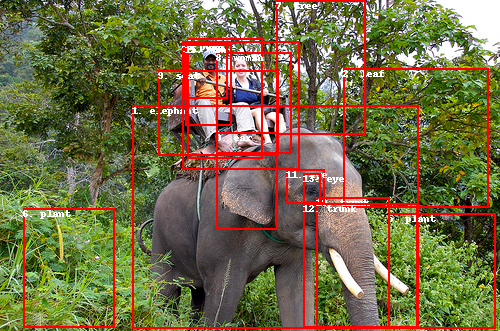

In [12]:
idx = 0 # 0
which = key[idx]
print(part_list[which].to_string(index=False))
i = which
img_id = test_data.split_mask.nonzero()[0][i]
gt_box = test_data.get_groundtruth(i)
print(f"Object 개수: {len(gt_box)}, Relation 개수: {len(part_list[which])}")
# Set of object having relation
sub = part_list[which]['Subject'].str.split('.', expand=True)
obj = part_list[which]['Object'].str.split('.', expand=True)
sub_set = set(sub[0].astype(int)); obj_set = set(obj[0].astype(int))
ent_set = sub_set | obj_set 
ent_set = [0,1] # select the number
show_all = True
show_image_all(img_id, vg_sgg, image_info, ent_set, None, show_all)

## Object를 기준으로 이미지 뽑기

In [17]:
seed = 3

np.random.seed(seed)
count = 1000
cur_count = 0
part_list = {}
flag = False

obj_candidate = {'man', 'board', 'handle', 'shirt'} # screen
n_obj = len(obj_candidate) - 1
# obj_candidate = None
for i in np.random.choice(n_test, n_test, replace=False):
    # part_list[i] = []
    pd_dict = {}
    predicate_type = [vg_sgg_dicts['idx_to_predicate'][str(p.item())] for _, _, p in gt_triplet['relative_triplet'][i]]
    obj_type = [vg_sgg_dicts['idx_to_label'][str(ent.item())] for ent in gt_triplet['labels'][i]]
    predicate_type_set = set(predicate_type)
    obj_type_set = set(obj_type)
    gt_label = gt_triplet['labels'][i].numpy()
    set_label = np.arange(len(gt_triplet['labels'][i].numpy()))
    intersection = obj_candidate & obj_type_set
    if (obj_candidate != None and len(intersection) > n_obj) or obj_candidate == None:
        for j in set_label:
            for j1 in set_label:
                if j != j1:
                    pd_dict[(j, j1)] = ['-', '-'] # GT(0), BGNN Score, BGNN_Global Score

        for k, (s, o, p) in enumerate(gt_triplet['relative_triplet'][i].numpy()):
            pd_dict[(s, o)][0] = vg_sgg_dicts['idx_to_predicate'][str(p)]
        sub = []
        obj = []
        gt = []
        for k , v in pd_dict.items():
            sub.append(f"{k[0]}. {vg_sgg_dicts['idx_to_label'][str(gt_label[k[0]])]}")
            obj.append(f"{k[1]}. {vg_sgg_dicts['idx_to_label'][str(gt_label[k[1]])]}")
            gt.append(v[0])
        temp_pd = pd.DataFrame({'Subject': sub, 'Object': obj, 'GT' : gt}) # BGNN 이후에 추가
        d = temp_pd[temp_pd['GT'] != '-']
        part_list[i] =d
        cur_count += 1
        if cur_count > count:
            flag= True
        if flag:
            break
key = list(part_list.keys())

## BGNN

  Subject  Object  GT
7. person 3. head has
Object 개수: 11, Relation 개수: 1


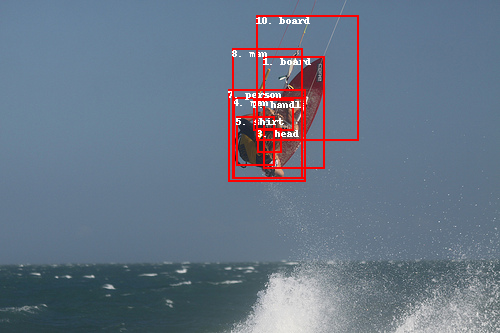

In [28]:
idx = 2 # 7, 31, 39 : boat 사진
which = key[idx]
print(part_list[which].to_string(index=False))
i = which
img_id = test_data.split_mask.nonzero()[0][i]
gt_box = test_data.get_groundtruth(i)
print(f"Object 개수: {len(gt_box)}, Relation 개수: {len(part_list[which])}")
# Set of object having relation
sub = part_list[which]['Subject'].str.split('.', expand=True)
obj = part_list[which]['Object'].str.split('.', expand=True)
sub_set = set(sub[0].astype(int)); obj_set = set(obj[0].astype(int))
ent_set = sub_set | obj_set
sub_obj = list(obj_candidate)
show_all = False
show_image_all(img_id, vg_sgg, image_info, ent_set, sub_obj, show_all)

In [14]:
for k1, v1 in category_per_class_corr.items():
    for k2 in v1.keys():
        if category_per_class_freq[k1][k2] !=0:
            category_per_class_acc[k1][k2] = category_per_class_corr[k1][k2] / float(category_per_class_freq[k1][k2])
        else:
            category_per_class_acc[k1][k2] = 0.0

for k1, v1 in category_per_class_corr_bgnn.items():
    for k2 in v1.keys():
        if category_per_class_freq_bgnn[k1][k2] !=0:
            category_per_class_acc_bgnn[k1][k2] = category_per_class_corr_bgnn[k1][k2] / float(category_per_class_freq_bgnn[k1][k2])
        else:
            category_per_class_acc_bgnn[k1][k2] = 0.0

## Train Predicate Distribution

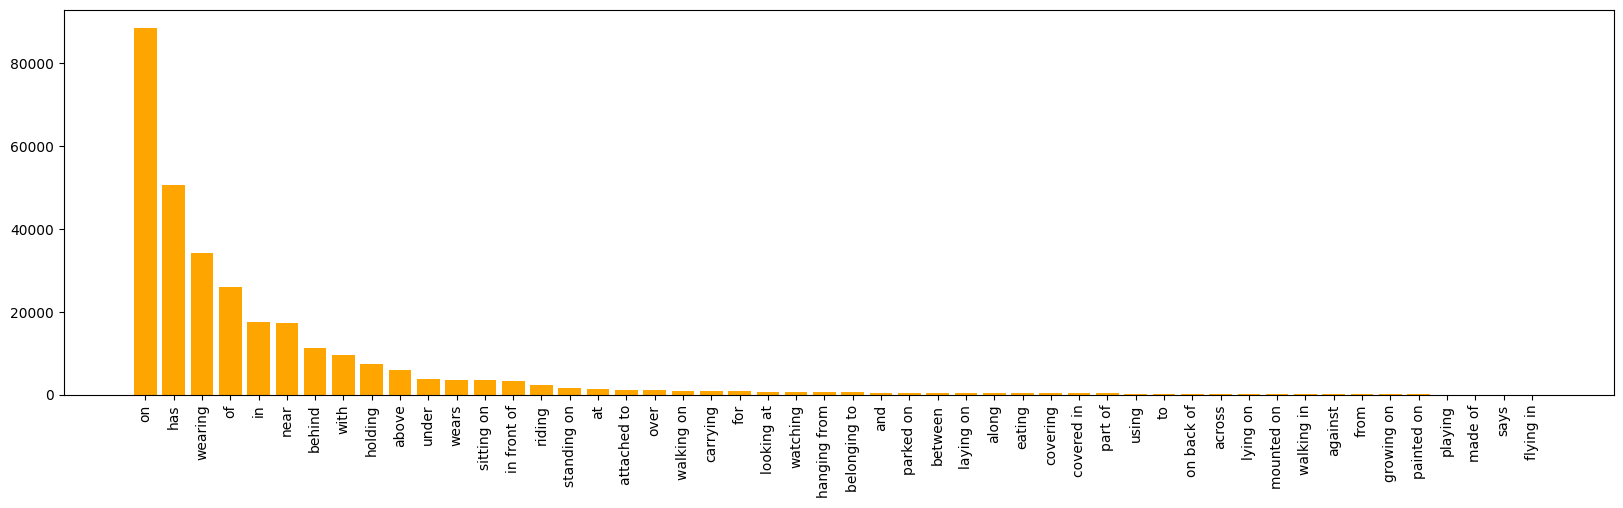

In [15]:
predicate_count_sort = dict(sorted(predicate_count.items(), key=lambda k:k[1], reverse=True))
sort_key = list(predicate_count_sort.keys())
plt.figure(figsize=(20,5))
x_name = list(predicate_count_sort.keys())
y_val = list(predicate_count_sort.values())
x_axis = np.arange(len(x_name))
plt.bar(x_axis, y_val, color='orange')
plt.xticks(x_axis, x_name, rotation=90)
plt.show()